In [5]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime
from torchvision.transforms import transforms 
from torchvision.utils import make_grid
import torch.nn as nn
import time
import os
import copy
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

/var/folders/6r/r5dfhtxd75g2p4pkybxl8jcc0000gn/T/ipykernel_37621/1205883626.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [6]:
# local data_dir 
# data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNet"
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
model_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/"
# train/val/test dir CHANGE TO 64 or 255
data_file_path = data_dir + "/preprocessed_data/train_64_noreroofs_bias.npy"
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"
val_data_file_path = data_dir + "/preprocessed_data/val_64_noreroofs.npy"

In [7]:
import sys
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/utils")
from data import ImageDataset

In [8]:
# import Roofnet
# from Roofnet.utils.data import ImageDataset
from torchvision.transforms import transforms 


transform_chain = transforms.Compose([
                        transforms.ToPILImage(mode='RGB'),
                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
data = ImageDataset(data_file_path,
                    transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
len(data), len(dataloader)


Loading data
Done loading data
Length 1050
Num Roofs 150


(1050, 33)

In [9]:
sample = data[0]  # get a sample from the dataset
print(type(sample))
print(len(sample))  # check the length of the tuple
print(sample[0])  # check the shape of the image tensor

<class 'tuple'>
3
tensor([[[0.5020, 0.4745, 0.4588,  ..., 0.2471, 0.3137, 0.3647],
         [0.5373, 0.5373, 0.5137,  ..., 0.2510, 0.2510, 0.3529],
         [0.5176, 0.5373, 0.5373,  ..., 0.2627, 0.2745, 0.3020],
         ...,
         [0.2235, 0.2235, 0.2235,  ..., 0.2745, 0.3333, 0.3373],
         [0.2980, 0.3137, 0.3059,  ..., 0.2980, 0.3294, 0.3373],
         [0.5137, 0.5176, 0.5020,  ..., 0.2824, 0.2824, 0.2588]],

        [[0.5098, 0.4902, 0.4745,  ..., 0.2392, 0.3098, 0.3765],
         [0.5412, 0.5490, 0.5255,  ..., 0.2431, 0.2392, 0.3569],
         [0.5255, 0.5490, 0.5373,  ..., 0.2471, 0.2510, 0.2902],
         ...,
         [0.2235, 0.2235, 0.2314,  ..., 0.2745, 0.3294, 0.3373],
         [0.2980, 0.3137, 0.3098,  ..., 0.2980, 0.3216, 0.3333],
         [0.5176, 0.5176, 0.5020,  ..., 0.2824, 0.2824, 0.2588]],

        [[0.5020, 0.4745, 0.4588,  ..., 0.2314, 0.2902, 0.3373],
         [0.5373, 0.5373, 0.5137,  ..., 0.2353, 0.2235, 0.3176],
         [0.5059, 0.5294, 0.5255,  ..., 

In [10]:
# Fixed input for debugging
fixed_x = next(iter(dataloader))
fixed_x = fixed_x[0]
print(fixed_x.shape)
# torch.Size([32, 3, 255, 255]) or torch.Size([32, 3, 64, 64])

torch.Size([32, 3, 64, 64])


In [11]:
# Set default parameters
image_channels = fixed_x.size(1)

img_dim = fixed_x.size(-1)
print(img_dim)

64


In [12]:
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(img_dim = img_dim, image_channels=image_channels, z_dim=128,device=device).to(device)

In [14]:
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_VAE_64_1.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1024, bias=True)
)

# Build binary classifier on latents

In [15]:
from torch.autograd import Variable

## Helper functions:

In [16]:
# Inputs: latent image 1, latent image 2, classification model, and prob threshold
# Returns binary classification, 1 for reroof, 0 for none.
# classifying two images as reroof if the probability is greater than the threshold

def classify_image_pair(latent_1,latent_2,model,prob_threshold=0.5):    # model is the classification model
    v_1 = np.hstack((latent_1,latent_2)) # concatenate the two latent vectors
    v_2 = np.hstack((latent_2,latent_1)) # concatenate the two latent vectors
    model.eval()
    p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
    p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
    prob = max([p_1.item(),p_2.item()]) # take the max probability
    return prob >= prob_threshold # return 1 if the probability is greater than the threshold, 0 otherwise

In [17]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on first transition detected
# If no transition detected, returns 0
def gen_predictions(latents,meta,model,prob_threshold=0.5): 
    out = [] 
    for i in range(len(latents)): # for each building
        hold = [] # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0])) # append the address
        trans_year = 0 # initialize the transition year
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            if classify_image_pair(latents[i][j],latents[i][j+1],model,prob_threshold=prob_threshold): # if the pair is classified as a reroof
                trans_year = j + 2013   # set the transition year to the year of the pair
                break
        hold.append(trans_year)  # append the transition year
        hold.append(int(meta[i][1])) # append the actual transition year
        out.append(hold) # append the list to the output
    return np.array(out) # return the output as an array

In [18]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on highest probability
# If no transition detected, returns 0
def get_max_prob(latents,meta,model,prob_threshold=0.5): 
    out = []
    for i in range(len(latents)): # for each building
        hold = []  # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0]))   # append the address
        trans_year = 0
        temp = [] # hold the probabilities
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            latent_1 = latents[i][j] # get the latent vectors
            latent_2 = latents[i][j+1] # get the latent vectors
            v_1 = np.hstack((latent_1,latent_2)) # concatenate the latent vectors
            v_2 = np.hstack((latent_2,latent_1)) # concatenate the latent vectors
            model.eval()
            p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
            p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
            prob = max([p_1.item(),p_2.item()]) # take the max probability
            temp.append(prob) # append the probability
        index = np.argmax(temp)     # get the index of the max probability
        if temp[index]>=prob_threshold: # if the max probability is greater than the threshold
            trans_year = 2013 + index # set the transition year to the year of the max probability 
        hold.append(trans_year) # append the transition year
        hold.append(int(meta[i][1]))       # append the actual transition year
        out.append(hold)    # append the list to the output
    return np.array(out)    # return the output as an array

In [19]:
# Generates accuracy metrics for detecting reroof and predicting reroof date
# No reroof is defined as a building that has no reroof in the dataset
# Reroof is defined as a building that has a reroof in the dataset
def gen_metrics(acc_metric, latents, meta, model, threshold=0.5):   
    no_reroof_pred = [] # hold the predictions for buildings with no reroof
    reroof_pred = [] # hold the predictions for buildings with a reroof
    hold = acc_metric(latents,meta, net ,threshold) # get the predictions
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2]))) # print the overall accuracy
    for i in hold: # for each building
        if int(i[2])==0:    # if the building has no reroof
            no_reroof_pred.append(int(int(i[1]) == 0))      # append the prediction
        else:
            reroof_pred.append(int(i[1]==i[2]))         # append the prediction
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    return hold

In [20]:
# Inputs: file path for data
# Outputs: Dataloader for training

def gen_dataloader(data_file_path):     
    transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
    data = ImageDataset(data_file_path,
                        transform=transform_chain)

    dataloader = torch.utils.data.DataLoader(data, batch_size=7, shuffle=False)
    dataloader = iter(dataloader)
    return dataloader

In [21]:
# Input: dataloader, latent generating model
# Outputs: Latents generate by model, meta data for buildings
# Generates latents for all buildings in dataloader
def gen_latents(dataloader, model): # generate latents for all buildings in dataloader
    latents = [] # hold the latents for the buildings
    meta = [] # hold the meta data for the buildings
    for i in dataloader: # for each building
        images = i[0] # get the images
        _, z, _, _ = model(images.to(device)) # get the latents
        z = z.detach().cpu().numpy()    # detach the latents in order to append to list
        latents.append(z)  # append the latents
        meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])     # append the meta data
    latents = np.array(latents)     # convert the latents to an array
    return latents, meta    

In [22]:
# Inputs: Latents of data, meta for building
# Output: All possible pairs of latent images and their label 1:reroof, 0:no reroof
# Generates all possible pairs of latent images and their label 1:reroof, 0:no reroof
# Used for training binary classifier

def gen_binary_data(latents, meta):         # generate all possible pairs of latent images and their label 1:reroof, 0:no reroof
    data_hold = []  # hold the latent pairs
    label_hold = []     # hold the labels
    for i in range(len(latents)):   # for each building
        for j in range(len(latents[i])):    # for each latent vector
            for k in range(len(latents[i])):        # for each latent vector
                data_hold.append(np.hstack((latents[i][j],latents[i][k])))      # append the latent pair
                year_j = 2012+j < meta[i][1]        # get the year of the latent vector
                year_k = 2012+k < meta[i][1]        # get the year of the latent vector
                label_hold.append(float(year_j != year_k))    # append the label
    data_hold = np.array(data_hold)     # convert the data to an array
    label_hold = np.array(label_hold)   # convery the labels to an array
    
    return data_hold, label_hold

In [23]:
# train_epoch for binary classifier

def binary_train_epoch(model, opt, criterion, data, labels, data_loader, val_data, val_labels, val_data_loader, best_acc, logit=False):
    
    best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
    
    model.train() # set model to training mode
    loss_hold = [] # hold loss for each batch
    
    for i in iter(data_loader): # iterate through batches
        batch_size = len(i)   # get batch size
        x_batch = data[i]   # get batch data 
        y_batch = labels[i]    # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch)) # convert to torch variable
        y_batch = torch.tensor(y_batch, dtype=torch.float, device=device)       # convert to torch variable
        y_batch = y_batch.view(batch_size,-1)       # reshape to batch size
        
        opt.zero_grad()         # zero the parameter gradients
        y_hat = model(x_batch.to(model.device))         # forward pass, after the data is on the correct device, it is passed through the model
        loss = criterion(y_hat,y_batch, model, x_batch)     # calculate loss 
        loss.backward()         # backward pass
        opt.step()          # update parameters
        
        loss_hold.append(loss.item()/batch_size)            # append loss
    print("Epoch training loss:{:.3f}".format(np.mean(loss_hold)))   # print epoch loss
    
    #validate  

    model.eval()
    pred_acc = [] # hold prediction accuracy for each batch
    for i in iter(val_data_loader):     # iterate through batches
        batch_size = len(i)     # get batch size
        x_batch = val_data[i]       # get batch data
        y_batch = val_labels[i]     # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch))   # convert to torch variable
        
        if logit:   # if logit, use sigmoid
            y_logits = model(x_batch.to(model.device))       # forward pass
            s = nn.Sigmoid()    # sigmoid function
            y_hat = s(y_logits) > 0.5     # get prediction
        else:
            y_hat = model(x_batch.to(model.device))>0.5     # forward pass, get prediction
        
        pred_acc.append(np.mean(y_hat.cpu().numpy() == y_batch.reshape(batch_size,-1))) # append prediction accuracy
        
    pred_acc = np.mean(pred_acc)    # get epoch prediction accuracy
    print("Epoch validation accuracy: {:.3f}%".format(pred_acc))        # print epoch prediction accuracy
    
    if pred_acc >= best_acc:        # if epoch prediction accuracy is better than best prediction accuracy
        best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
        best_acc = pred_acc     # update best prediction accuracy
    
    net.load_state_dict(best_model_wts)     # load best model weights
    
    return net, best_acc 
        
        

## Load the data

In [24]:
# z_dim = 128 is the dimension of the latent space
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir + 'roofnet_VAE_64_1.pth'))
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
data_file_path = data_dir + "preprocessed_data/train_64_noreroofs.npy"

binary_dataloader = gen_dataloader(data_file_path)

Loading data
Done loading data
Length 1050
Num Roofs 150


In [25]:
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

binary_val_dataloader = gen_dataloader(val_data_file_path)

Loading data
Done loading data
Length 175
Num Roofs 25


In [26]:
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"

binary_test_dataloader = gen_dataloader(test_data_file_path)

Loading data
Done loading data
Length 385
Num Roofs 55


In [27]:
latents, meta = gen_latents(binary_dataloader, model)
print(latents.shape)

(150, 7, 128)


In [28]:
val_latents, val_meta = gen_latents(binary_val_dataloader, model)
print(val_latents.shape)

(25, 7, 128)


In [29]:
test_latents, test_meta = gen_latents(binary_test_dataloader, model)


In [30]:
data_hold, label_hold = gen_binary_data(latents, meta)

print(data_hold.shape)
print(data_hold)
print(label_hold)

(7350, 256)
[[ 9.69748572e-02  9.09221590e-01 -1.35119632e-03 ... -2.39294633e-01
   7.75825560e-01  1.10238045e-01]
 [ 9.69748572e-02  9.09221590e-01 -1.35119632e-03 ... -2.87907302e-01
   6.48093760e-01  1.46847740e-01]
 [ 9.69748572e-02  9.09221590e-01 -1.35119632e-03 ... -3.16943616e-01
   8.53884995e-01  1.82541594e-01]
 ...
 [ 3.83716464e-01  2.10825622e-01 -5.17932177e-01 ... -1.29445970e-01
  -1.81929076e+00  6.36077285e-01]
 [ 3.83716464e-01  2.10825622e-01 -5.17932177e-01 ... -7.27182701e-02
  -1.33987367e+00  5.92615008e-01]
 [ 3.83716464e-01  2.10825622e-01 -5.17932177e-01 ... -9.63632241e-02
  -1.48249257e+00  6.28646195e-01]]
[0. 0. 0. ... 0. 0. 0.]


In [31]:
val_hold, val_label = gen_binary_data(val_latents, val_meta)
print(val_hold.shape)

(1225, 256)


In [32]:
test_hold, test_label = gen_binary_data(test_latents, test_meta)
print(test_hold.shape)

(2695, 256)


In [33]:
# to check the number of reroofs and no reroofs in the dataset
# it is because we have 7 images for builidings and if there is a reroof, the count of reroofs will be smaller
reroof_count = np.sum(label_hold == 1)
no_reroof_count = np.sum(label_hold == 0)

print(f"Reroof count: {reroof_count}")
print(f"No Reroof count: {no_reroof_count}")


Reroof count: 1828
No Reroof count: 5522


In [34]:
index_loader = torch.utils.data.DataLoader(np.arange(len(data_hold)),batch_size=32,shuffle=True) # index loader is used to shuffle the data
val_index_loader = torch.utils.data.DataLoader(np.arange(len(val_hold)),batch_size=32,shuffle=True)

In [35]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



In [36]:
# model.load_state_dict(torch.load(model_dir + '/roofnet_binary_class_first_try.pth'))

# Evaluation

## Finding Noise

In [37]:
import numpy as np


print("Minimum value in test_hold:", np.min(test_hold))
print("Maximum value in test_hold:", np.max(test_hold))


Minimum value in test_hold: -7.3537364
Maximum value in test_hold: 7.0177975


In [38]:
# Given values
min_value = -7.353739
max_value = 7.0177917

# Calculate range
data_range = max_value - min_value

# Set noise_std_dev as a fraction of the range
x = 10
noise_std_dev = data_range / x

print("Standard Deviation of Noise:", noise_std_dev)


Standard Deviation of Noise: 1.4371530700000001


In [39]:
# Different values of x
x_values = [4, 10, 15, 20, 25]

# Compute noise_std_dev for each x value
std_devs = [data_range / x for x in x_values]

# Print the results
for x, std_dev in zip(x_values, std_devs):
    print(f"For x = {x}, noise_std_dev = {std_dev:.4f}")

For x = 4, noise_std_dev = 3.5929
For x = 10, noise_std_dev = 1.4372
For x = 15, noise_std_dev = 0.9581
For x = 20, noise_std_dev = 0.7186
For x = 25, noise_std_dev = 0.5749


In [40]:
data_range = max_value - min_value

for noise_percentage in [0.01, 0.10, 0.25, 0.50]:  # 1%, 10%, 25%, and 50% of the data range
    noise_std_dev = data_range * noise_percentage
    print(f'Noise standard deviation for {noise_percentage*100:.0f}% of the data range: {noise_std_dev:.4f}')


Noise standard deviation for 1% of the data range: 0.1437
Noise standard deviation for 10% of the data range: 1.4372
Noise standard deviation for 25% of the data range: 3.5929
Noise standard deviation for 50% of the data range: 7.1858


# XAI Explanation Robustness

## XAI Explanation Robustness for one model

In [41]:
# instantiate your model
model = Net()  
model.load_state_dict(torch.load(model_dir + 'roofnet_binary_class_shap_1.pth'))

# enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (network): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [39]:
# INPUT PERTURBATION FUNCTION
def perturb_set(data, perturbation_size):
    """
    Add Gaussian noise to latent vectors.

    Args:
    latent_vectors (np.ndarray or torch.Tensor): The original latent vectors.
    perturbation_size (float): The standard deviation of the Gaussian noise to be added.

    Returns:
    torch.Tensor: The perturbed latent vectors.
    """
    # Convert numpy array to tensor if necessary
    if isinstance(data, np.ndarray):
        data = torch.tensor(data).float().to(device)
    
    noise = torch.normal(mean=0, std=perturbation_size, size=data.shape).to(data.device)
    perturbed_vectors = data + noise
    return perturbed_vectors

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, else CPU
perturbation_size = 0.1  # for example
perturbed_test_hold = perturb_set(test_hold, perturbation_size)
print(perturbed_test_hold)

tensor([[ 0.5326,  0.6951, -0.3278,  ..., -0.4323, -0.2739,  0.4003],
        [ 0.5328,  0.5528, -0.5596,  ...,  0.2928, -0.0337, -0.1030],
        [ 0.3521,  0.8147, -0.6414,  ..., -0.4139, -0.3088,  0.3354],
        ...,
        [-0.0887,  0.0411,  0.0393,  ...,  0.0414, -0.1093, -0.0746],
        [-0.2995, -0.1046,  0.0985,  ...,  0.1767,  0.2477, -0.1759],
        [ 0.0931, -0.1118, -0.1340,  ...,  0.0386,  0.0244,  0.0832]])


In [40]:
# Specify the path false name
save_path = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/preprocessed_data.pt"

# Save the tensor
torch.save(perturbed_test_hold, save_path)


In [91]:
import shap

def create_explainer(model, data):
    """
    Create a SHAP explainer for a given model.

    Args:
    model (torch.nn.Module): A PyTorch model.
    data (numpy.ndarray): A numpy array containing background data samples.

    Returns:
    explainer (function): A function that can compute SHAP values for a given model and data.
    """
    
    # define a function that will make predictions using your model
    def model_predict(data_asarray):
        
        # convert numpy data to PyTorch tensor
        data_asarray = torch.tensor(data_asarray, dtype=torch.float32).to(model.device)

        # model prediction
        model_pred = model(data_asarray)

        return model_pred.detach().cpu().numpy()
    
    # create a Kernel SHAP explainer
    explainer = shap.KernelExplainer(model_predict, data)
    
    return explainer


In [92]:
# explanation robustness for a normal data
background_data = test_hold[:100]  # use 100 data points as background data 
test_data = test_hold[100:200]  # use 100 data points as test data for which shap values are computed
explainer_model1 = create_explainer(model, background_data)
shap_values_model1 = explainer_model1.shap_values(test_data)


In [93]:
# explanation robusntess for a perturbed data
background_data_perturb = perturbed_test_hold[:100]  # use 100 data points as background data 
test_data_perturb = perturbed_test_hold[100:200] 
test_data_perturb= test_data_perturb.detach().cpu().numpy()
shap_values_perturbed_model1 = explainer_model1.shap_values(test_data_perturb)

  0%|          | 0/100 [00:00<?, ?it/s]

In [94]:
# explanation robustness
shap_values_model1_np = np.array(shap_values_model1)
shap_values_perturbed_model1_np = np.array(shap_values_perturbed_model1)

robustness_model1 = np.mean(np.abs(shap_values_model1_np - shap_values_perturbed_model1_np))
print(f"Robustness: {robustness_model1}")


## XAI Explanation Robustness for 3 Models 

In [41]:
import numpy as np
import pandas as pd
import torch
import shap
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [42]:
def perturb_set(data, perturbation_size):
    """
    Add Gaussian noise to latent vectors.

    Args:
    latent_vectors (np.ndarray or torch.Tensor): The original latent vectors.
    perturbation_size (float): The standard deviation of the Gaussian noise to be added.

    Returns:
    torch.Tensor: The perturbed latent vectors.
    """
    # Convert numpy array to tensor if necessary
    if isinstance(data, np.ndarray):
        data = torch.tensor(data).float().to(device)
    
    noise = torch.normal(mean=0, std=perturbation_size, size=data.shape).to(data.device)
    perturbed_vectors = data + noise
    return perturbed_vectors


def create_explainer(model, data):
    """
    Create a SHAP explainer for a given model.

    Args:
    model (torch.nn.Module): A PyTorch model.
    data (numpy.ndarray): A numpy array containing background data samples.

    Returns:
    explainer (function): A function that can compute SHAP values for a given model and data.
    """
    
    # define a function that will make predictions using your model
    def model_predict(data_asarray):
        
        # convert numpy data to PyTorch tensor
        data_asarray = torch.tensor(data_asarray, dtype=torch.float32).to(model.device)

        # model prediction
        model_pred = model(data_asarray)

        return model_pred.detach().cpu().numpy()
    
    # create a Kernel SHAP explainer
    explainer = shap.KernelExplainer(model_predict, data)
    
    return explainer



In [43]:
# Assuming you've defined the model architecture somewhere as 'Net'
model_paths = [
    '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_binary_class_shap_in_the_batch_var01.pth',
    '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_binary_class_shap_in_the_batch_var03.pth',
    '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_binary_class_1.pth'
]

# Placeholders for results
results = {
    'Perturbation Size': [],
    'Model 1': [], #shap var01
    'Model 2': [], #shap var03
    'Model 3': [] #sota
}

perturbation_sizes = [0.01, 0.1, 0.25, 0.5]  # Perturbation sizes 

for perturbation in perturbation_sizes:
    results['Perturbation Size'].append(perturbation)

    for idx, model_path in enumerate(model_paths):
        # Load the model
        model = Net()
        model.load_state_dict(torch.load(model_path))
        model.to(device)

        # Perturb data
        perturbed_data = perturb_set(test_hold, perturbation)

        # Compute explanation robustness
        background_data = test_hold[:100]
        test_data_sample = test_hold[100:200]

        explainer = create_explainer(model, background_data)
        shap_values = explainer.shap_values(test_data_sample)

        background_data_perturb = perturbed_data[:100]
        test_data_perturb_sample = perturbed_data[100:200].detach().cpu().numpy()

        shap_values_perturbed = explainer.shap_values(test_data_perturb_sample)

        robustness = np.mean(np.abs(np.array(shap_values) - np.array(shap_values_perturbed)))

        model_name = f"Model {idx + 1}"
        results[model_name].append(robustness)

# Plot results
plt.figure(figsize=(10, 6))
for model_name in ['Model 1', 'Model 2', 'Model 3']:
    plt.plot(results['Perturbation Size'], results[model_name], label=model_name)
    
plt.xlabel('Perturbation Size')
plt.ylabel('Robustness')
plt.title('Robustness vs. Perturbation Size for Different Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("robustness_comparisonvar0103.png")
plt.show()

# Save results to a DataFrame and then to a CSV
df = pd.DataFrame(results)
df.to_csv("robustness_results_var0103.csv", index=False)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Models' Robustness

## Robustness for one model

In [46]:
# instantiate your model
model = Net()  
model.load_state_dict(torch.load(model_dir + 'roofnet_binary_class_run3.pth'))

# enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (network): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [331]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def add_gaussian_noise(data, mean=0, std_dev=0.1):
    noise = np.random.normal(mean, std_dev, data.shape)
    return data + noise

def evaluate_model_on_noise(data, true_labels, model, device, noise_std_dev):
    # Add Gaussian noise
    perturbed_data = add_gaussian_noise(data, std_dev=noise_std_dev)

    # Convert numpy data to PyTorch tensor and send to device
    perturbed_data = torch.tensor(perturbed_data, dtype=torch.float32).to(device)

    # Make predictions with the model
    with torch.no_grad():
        predictions = model(perturbed_data)

    # Convert model outputs to binary predictions (assuming sigmoid activation in last layer)
    predicted_labels = (predictions > 0.5).float().cpu().numpy()

    # Return the accuracy on perturbed data
    return accuracy_score(true_labels, predicted_labels)

def robustness_analysis(data, labels, model, device, std_dev_range=np.linspace(0, 1, 10)):
    accuracies = []
    for std_dev in std_dev_range:
        accuracy = evaluate_model_on_noise(data, labels, model, device, std_dev)
        accuracies.append(accuracy)
    
    plt.figure(figsize=(10, 6))
    plt.plot(std_dev_range, accuracies, '-o')
    plt.title('Robustness Analysis using Gaussian Noise')
    plt.xlabel('Standard Deviation of Noise')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return accuracies


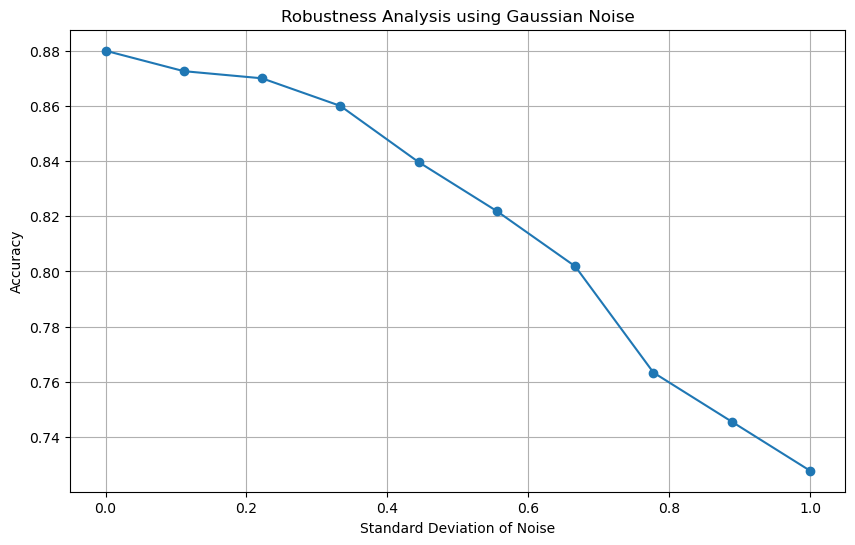

In [332]:
# Assuming test_hold and test_label are defined and contain the test data and labels
robustness_scores = robustness_analysis(test_hold, test_label, model, device)


## Robustness for models with different noise levels (1, 10, 25, 50 %)

In [51]:
# Instantiate and load your models
models = []
model_dir = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/'  # specify your path
model_names = model_names = ['roofnet_binary_class_run3.pth', 'roofnet_binary_class_run3varbatch02.pth', 'roofnet_binary_class_avg5301posneg.pth', 'roofnet_binary_class_avg5301pos.pth']
for name in model_names:
    model = Net()
    model.load_state_dict(torch.load(model_dir + name))
    model.eval()
    model.to(device)
    models.append(model)

# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def add_gaussian_noise(data, mean=0, std_dev=1):
    noise = np.random.normal(mean, std_dev, data.shape)
    return data + noise

def evaluate_model_on_noise(data, true_labels, model, device, noise_std_dev):
    # Add Gaussian noise
    perturbed_data = add_gaussian_noise(data, std_dev=noise_std_dev)

    # Convert numpy data to PyTorch tensor and send to device
    perturbed_data = torch.tensor(perturbed_data, dtype=torch.float32).to(device)

    # Make predictions with the model
    with torch.no_grad():
        predictions = model(perturbed_data)

    # Convert model outputs to binary predictions (assuming sigmoid activation in last layer)
    predicted_labels = (predictions > 0.5).float().cpu().numpy()

    # Return the accuracy on perturbed data
    return accuracy_score(true_labels, predicted_labels)

def robustness_analysis(data, labels, models, device, std_dev_range=[0.1437, 1.4372, 3.5929, 7.1858], n_iterations=250):
    model_accuracies = {}
    model_variances = {}

    for model, name in zip(models, model_names):
        mean_accuracies = []
        variances = []
        for std_dev in std_dev_range:
            acc_values = [evaluate_model_on_noise(data, labels, model, device, std_dev) for _ in range(n_iterations)]
            mean_accuracies.append(np.mean(acc_values))
            variances.append(np.var(acc_values))
        
        model_accuracies[name] = mean_accuracies
        model_variances[name] = variances
    # Save results to CSV
    df_accuracies = pd.DataFrame(model_accuracies, index=std_dev_range)
    df_accuracies.to_csv("model_accuracies_gnoiserun3.csv")

    df_variances = pd.DataFrame(model_variances, index=std_dev_range)
    df_variances.to_csv("model_variancesrungnoiserun3.csv")
    
    # Plot mean accuracies
    plt.figure(figsize=(12, 8))
    for name, accuracies in model_accuracies.items():
        plt.plot(std_dev_range, accuracies, '-o', label=name)
    plt.title('Robustness Analysis using Gaussian Noise')
    plt.xlabel('Standard Deviation of Noise')
    plt.ylabel(f'Mean Accuracy (n={n_iterations})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot variances
    plt.figure(figsize=(12, 8))
    for name, var in model_variances.items():
        plt.plot(std_dev_range, var, '-o', label=name)
    plt.title('Robustness Analysis using Gaussian Noise')
    plt.xlabel('Standard Deviation of Noise')
    plt.ylabel(f'Variance of Accuracy (n={n_iterations})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model_accuracies, model_variances


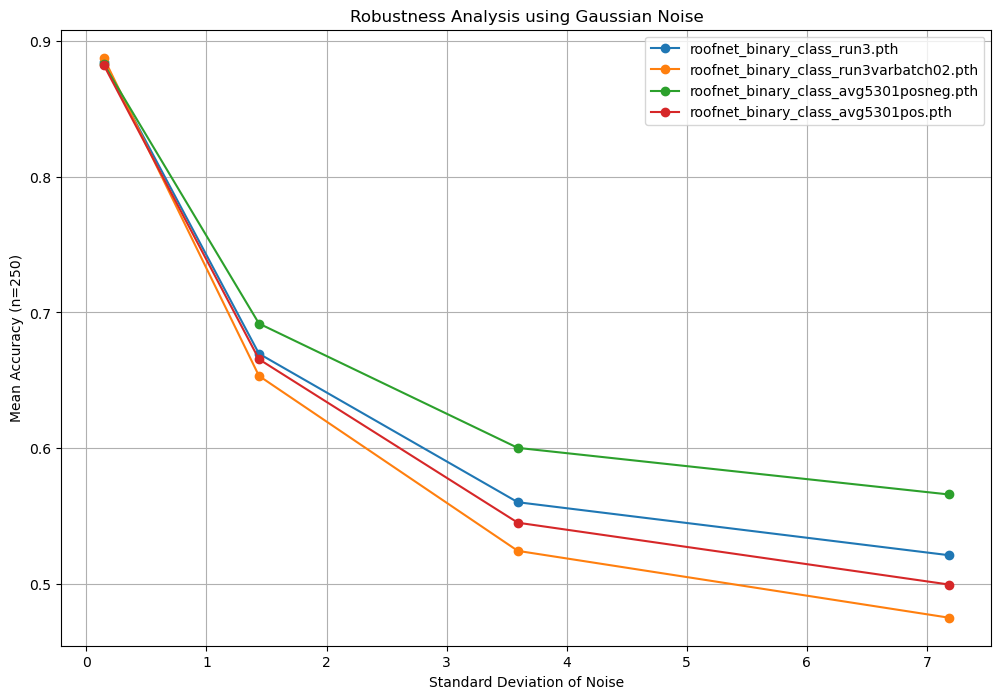

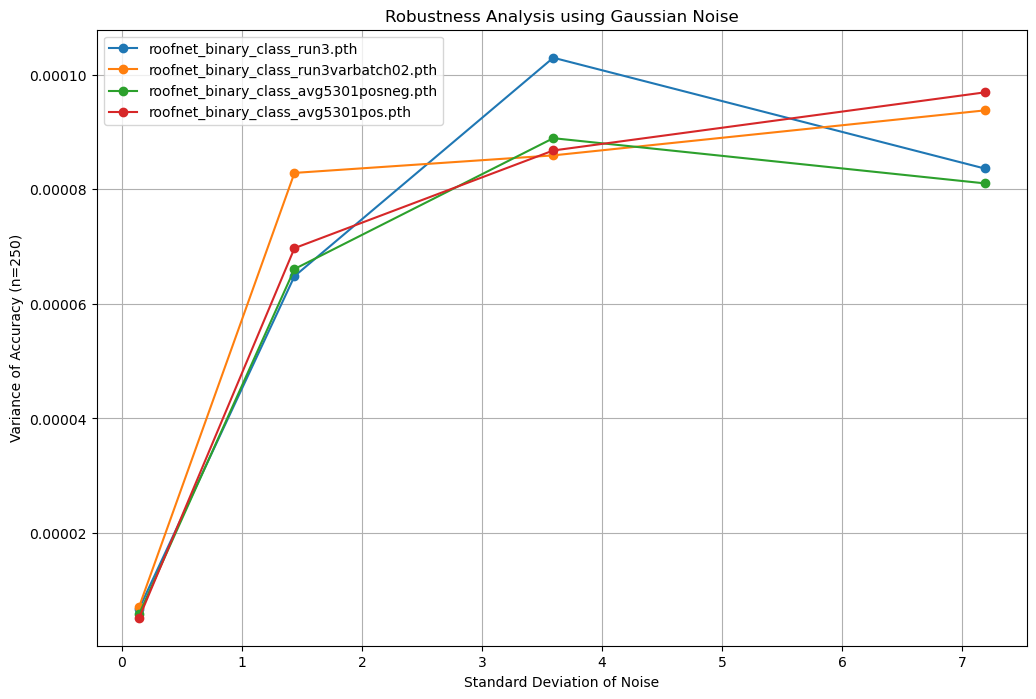

In [53]:
# Assuming test_hold and test_label are defined and contain the test data and labels
robustness_scores = robustness_analysis(test_hold, test_label, models, device)


## Robustness Confusion St dev

In [42]:
# Instantiate and load your models
model_dir = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/'  # specify your path
model_names = ['roofnet_binary_class_run3.pth', 'roofnet_binary_class_run3varbatch02.pth', 'roofnet_binary_class_avg5301posneg.pth', 'roofnet_binary_class_avg5301pos.pth']
models = []

for name in model_names:
    model = Net()
    model.load_state_dict(torch.load(model_dir + name))
    model.eval()
    model.to(device)
    models.append(model)

# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [45]:
from sklearn.metrics import confusion_matrix
def add_gaussian_noise(data, mean=0, std_dev=1):
    noise = np.random.normal(mean, std_dev, data.shape)
    return data + noise

def evaluate_model_on_noise_with_confusion(data, true_labels, model, device, noise_std_dev):
    # Add Gaussian noise
    perturbed_data = add_gaussian_noise(data, std_dev=noise_std_dev)

    # Convert numpy data to PyTorch tensor and send to device
    perturbed_data = torch.tensor(perturbed_data, dtype=torch.float32).to(device)

    # Make predictions with the model
    with torch.no_grad():
        predictions = model(perturbed_data)

    # Convert model outputs to binary predictions (assuming sigmoid activation in the last layer)
    predicted_labels = (predictions > 0.5).float().cpu().numpy().flatten()

    # Compute the confusion matrix
    conf_mat = confusion_matrix(true_labels, predicted_labels)
    
    # Calculate class-wise accuracy using the confusion matrix
    accuracy_class0 = conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1])
    accuracy_class1 = conf_mat[1][1] / (conf_mat[1][0] + conf_mat[1][1])

    # Return the class-wise accuracies
    return accuracy_class0, accuracy_class1

def robustness_analysis_confusion(data, labels, models, device, std_dev_range=[0.1437, 1.4372, 3.5929, 7.1858], n_iterations=250):
    model_accuracies = {name: {"class0": [], "class1": []} for name in model_names}
    model_variances = {name: {"class0": [], "class1": []} for name in model_names}

    for model, name in zip(models, model_names):
        for std_dev in std_dev_range:
            acc0_values, acc1_values = zip(*[evaluate_model_on_noise_with_confusion(data, labels, model, device, std_dev) for _ in range(n_iterations)])
            
            model_accuracies[name]["class0"].append(np.mean(acc0_values))
            model_accuracies[name]["class1"].append(np.mean(acc1_values))
            model_variances[name]["class0"].append(np.var(acc0_values))
            model_variances[name]["class1"].append(np.var(acc1_values))
            
    # Save results to CSV
    for cls in ["class0", "class1"]:
        df_accuracies = pd.DataFrame({name: model_accuracies[name][cls] for name in model_names}, index=std_dev_range)
        df_accuracies.to_csv(f"model_accuracies_{cls}_gnoiserun3classwise.csv")

        df_variances = pd.DataFrame({name: model_variances[name][cls] for name in model_names}, index=std_dev_range)
        df_variances.to_csv(f"model_variances_{cls}_gnoiserun3classwise.csv")

    # Plot mean accuracies and variances for each class
    for cls in ["class0", "class1"]:
        plt.figure(figsize=(12, 8))
        for name in model_names:
            plt.plot(std_dev_range, model_accuracies[name][cls], '-o', label=name)
        plt.title(f'Robustness Analysis using Gaussian Noise for {cls}')
        plt.xlabel('Standard Deviation of Noise')
        plt.ylabel(f'Mean Accuracy (n={n_iterations}) for {cls}')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 8))
        for name in model_names:
            plt.plot(std_dev_range, model_variances[name][cls], '-o', label=name)
        plt.title(f'Robustness Analysis using Gaussian Noise for {cls}')
        plt.xlabel('Standard Deviation of Noise')
        plt.ylabel(f'Variance of Accuracy (n={n_iterations}) for {cls}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return model_accuracies, model_variances



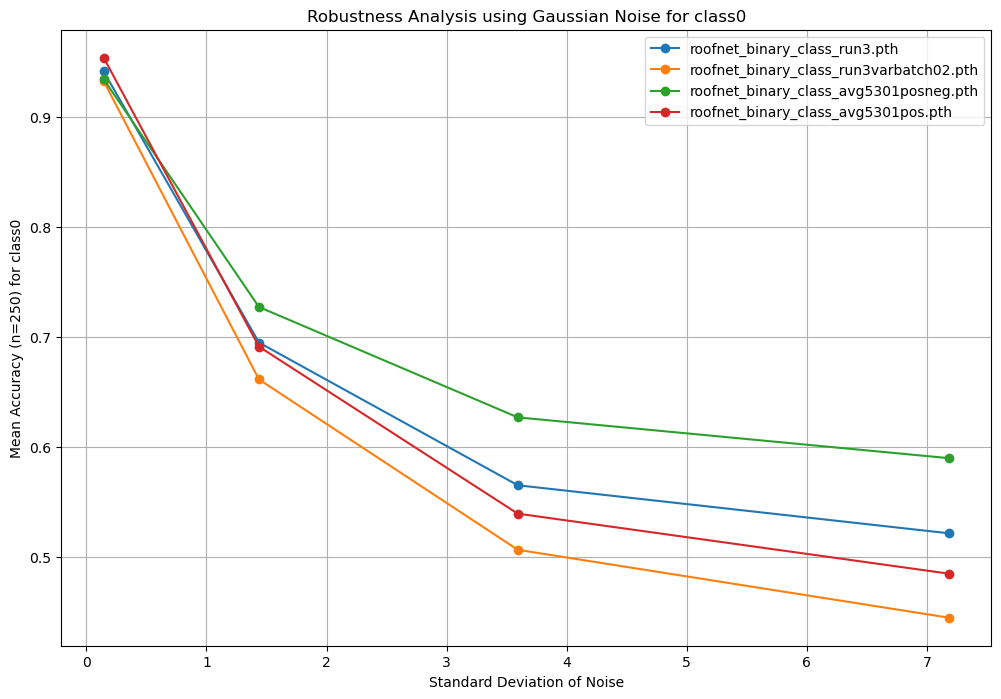

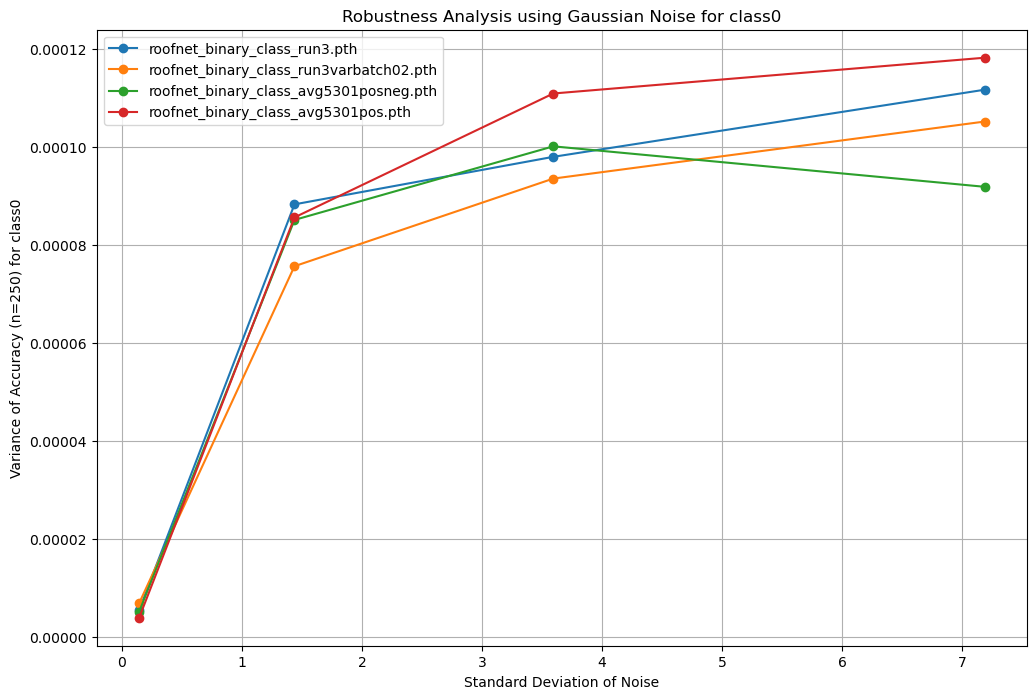

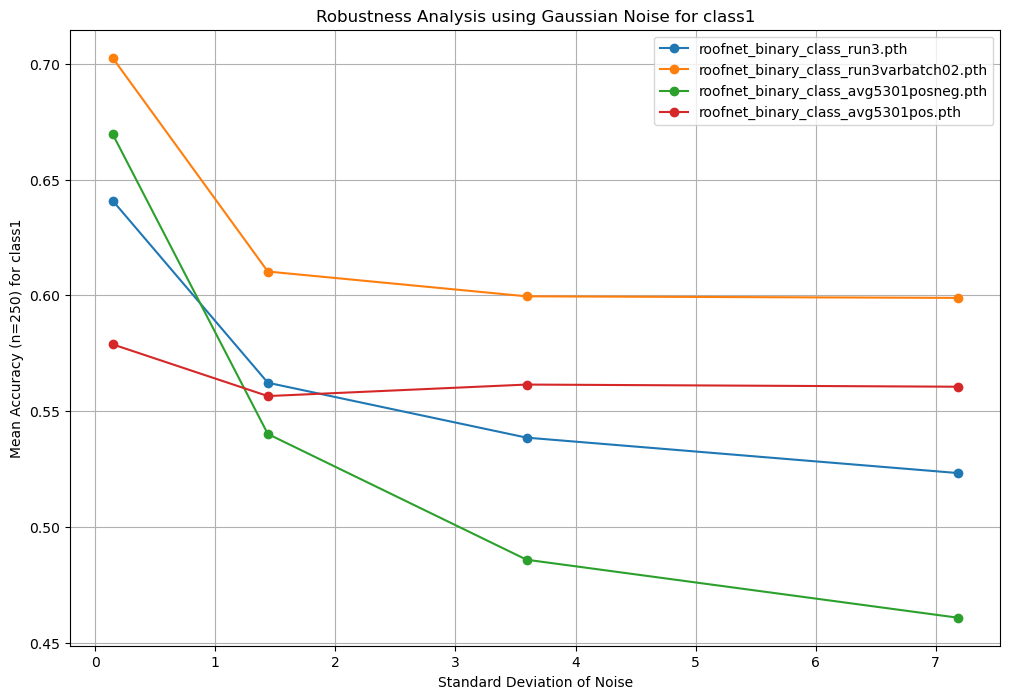

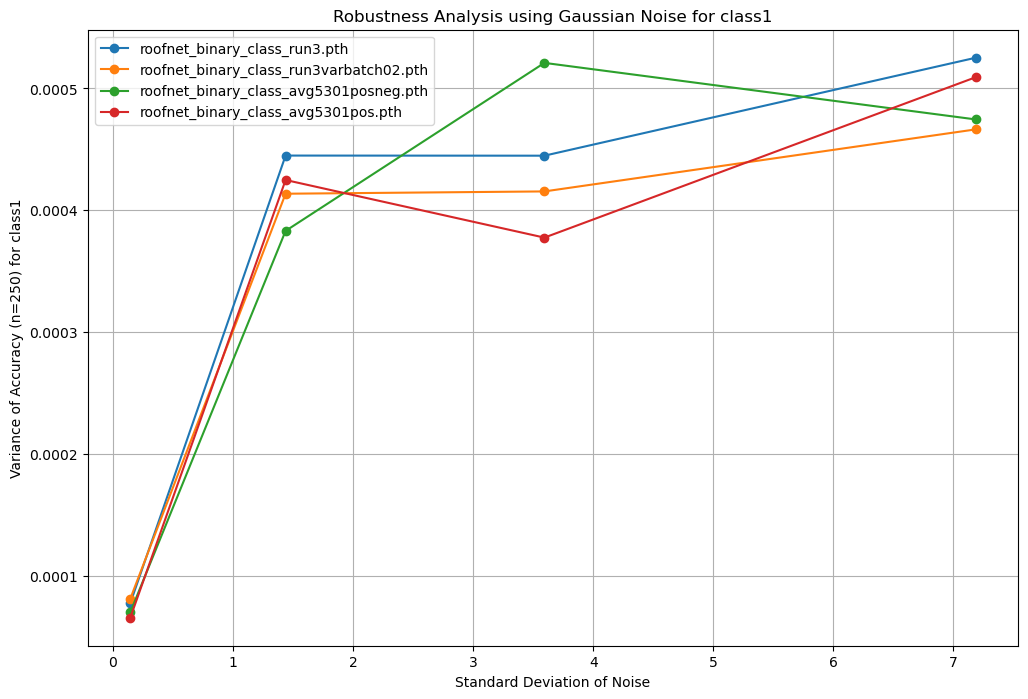

In [46]:
# Assuming test_hold and test_label are defined and contain the test data and labels
robustness_scores = robustness_analysis_confusion(test_hold, test_label, models, device)


# Robustness Interpolation

## Robustness with Interpolation noise choice std dev = _

In [57]:
# Instantiate and load your models
model_dir = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/'  # specify your path
model_names = ['roofnet_binary_class_run3.pth', 'roofnet_binary_class_run3varbatch02.pth', 'roofnet_binary_class_avg5301posneg.pth', 'roofnet_binary_class_avg5301pos.pth']
models = []

for name in model_names:
    model = Net()
    model.load_state_dict(torch.load(model_dir + name))
    model.eval()
    model.to(device)
    models.append(model)

# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def interpolate_with_normalized_noise(data, r, noise_std_dev=1.1, p=1.0):
    noise = np.random.normal(0, noise_std_dev, data.shape)
    
    # Normalize the noise to have a unit norm, and scale by p
    noise_norm = np.linalg.norm(noise, axis=1, keepdims=True)
    normalized_noise = (noise / noise_norm) * p
    
    p_new = (1 - r) * data + r * normalized_noise
    return p_new

def evaluate_model_on_interpolated_data(data, true_labels, model, device, r):
    # Interpolate data with noise
    interpolated_data = interpolate_with_normalized_noise(data, r)

    # Convert numpy data to PyTorch tensor and send to device
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    # Make predictions with the model
    with torch.no_grad():
        predictions = model(interpolated_data)

    # Convert model outputs to binary predictions 
    predicted_labels = (predictions > 0.5).float().cpu().numpy()

    # Return the accuracy on interpolated data
    return accuracy_score(true_labels, predicted_labels)

import numpy as np

def robustness_analysis_using_interpolation(data, labels, models, device, r_values=np.linspace(0, 1, 10), n_iterations=200):
    model_accuracies = {}
    model_variances = {}

    for model, name in zip(models, model_names):
        all_accuracies = []
        for r in r_values:
            accuracies_for_r = []
            for _ in range(n_iterations):
                accuracy = evaluate_model_on_interpolated_data(data, labels, model, device, r)
                accuracies_for_r.append(accuracy)
            all_accuracies.append(accuracies_for_r)

        mean_accuracies = np.mean(all_accuracies, axis=1)
        variance_accuracies = np.var(all_accuracies, axis=1)

        model_accuracies[name] = mean_accuracies 
        model_variances[name] = variance_accuracies

    # Plotting accuracies
    plt.figure(figsize=(12, 8))
    for name, accuracies in model_accuracies.items():
        plt.plot(r_values, accuracies, '-o', label=name)
        plt.fill_between(r_values, accuracies - np.sqrt(model_variances[name]), accuracies + np.sqrt(model_variances[name]), alpha=0.2)

    plt.title('Robustness Analysis using Data Interpolation - Mean Accuracies')
    plt.xlabel('Interpolation Factor r')
    plt.ylabel('Mean Accuracy over {} Iterations'.format(n_iterations))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting variances
    plt.figure(figsize=(12, 8))
    for name, variances in model_variances.items():
        plt.plot(r_values, variances, '-o', label=name)

    plt.title('Robustness Analysis using Data Interpolation - Variances')
    plt.xlabel('Interpolation Factor r')
    plt.ylabel('Variance over {} Iterations'.format(n_iterations))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(model_accuracies)
    results_df.insert(0, "Interpolation_Factor_r", r_values)  # Add the r_values as a column for reference
    results_df.to_csv('robustness_analysis_results_multiple_iterations.csv', index=False)

    return model_accuracies, model_variances


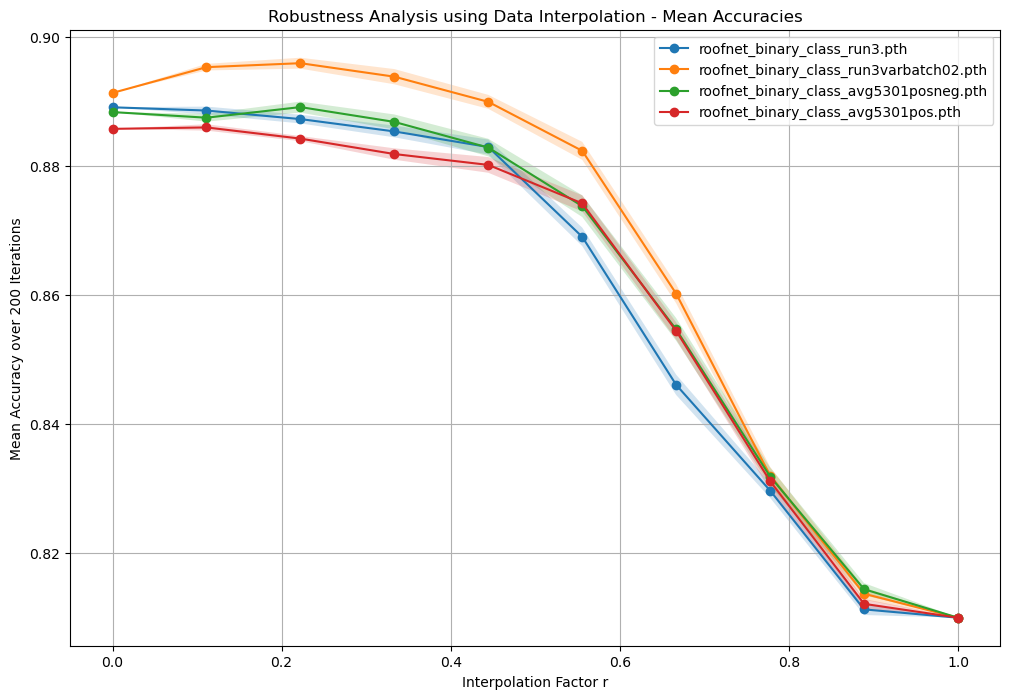

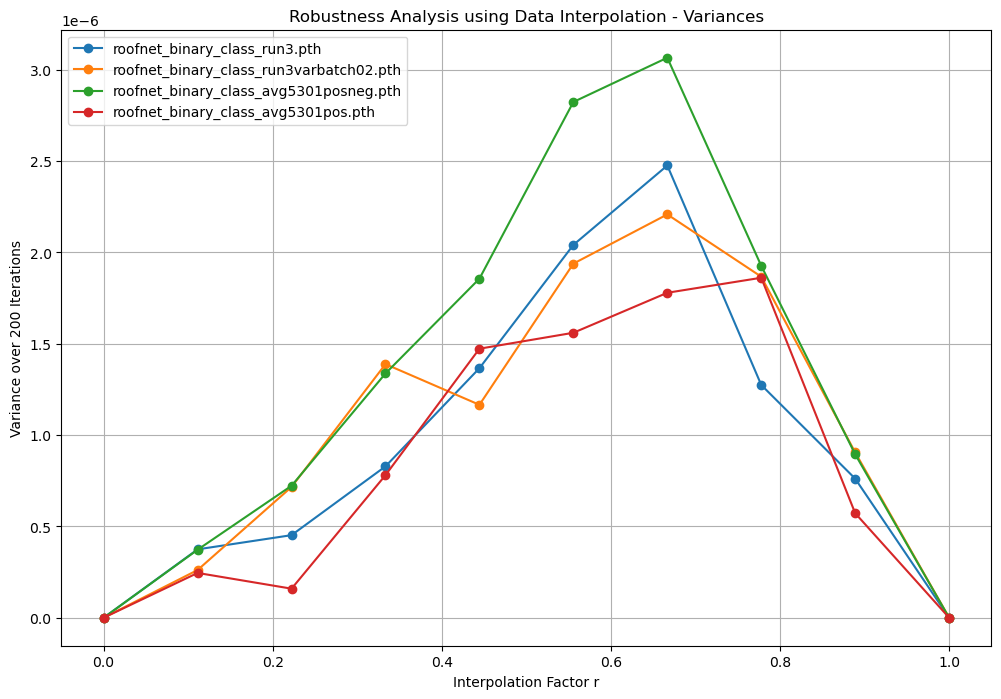

In [59]:
# Assuming test_hold and test_label are defined and contain the test data and labels
robustness_scores = robustness_analysis_using_interpolation(test_hold, test_label, models, device)

## Robustness with Data Interpolation and Different Noise Levels

### Simple Accuracy Score

In [60]:
# Instantiate and load your models
model_dir = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/'  # specify your path
model_names = ['roofnet_binary_class_run3.pth', 'roofnet_binary_class_run3varbatch02.pth', 'roofnet_binary_class_avg5301posneg.pth', 'roofnet_binary_class_avg5301pos.pth']
models = []

for name in model_names:
    model = Net()
    model.load_state_dict(torch.load(model_dir + name))
    model.eval()
    model.to(device)
    models.append(model)

# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def interpolate_with_normalized_noise(data, r, noise_std_dev=1.1, p=1.0):
    noise = np.random.normal(0, noise_std_dev, data.shape)
    
    # Normalize the noise to have a unit norm, and scale by p
    noise_norm = np.linalg.norm(noise, axis=1, keepdims=True)
    normalized_noise = (noise / noise_norm) * p
    
    p_new = (1 - r) * data + r * normalized_noise
    return p_new

def evaluate_model_on_interpolated_data(data, true_labels, model, device, r, noise_std_dev):
    # Interpolate data with noise
    interpolated_data = interpolate_with_normalized_noise(data, r, noise_std_dev)

    # Convert numpy data to PyTorch tensor and send to device
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    # Make predictions with the model
    with torch.no_grad():
        predictions = model(interpolated_data)

    # Convert model outputs to binary predictions 
    predicted_labels = (predictions > 0.5).float().cpu().numpy()

    # Return the accuracy on interpolated data
    return accuracy_score(true_labels, predicted_labels)
     
def robustness_analysis_using_interpolation(data, labels, models, device, r_values=np.linspace(0, 1, 10), noise_percentages=[0.01, 0.10, 0.25, 0.50], n_iterations=150):
    model_accuracies = {}
    model_variances = {}
    
    data_range = np.max(data) - np.min(data) 
    
    for noise_percentage in noise_percentages:
        noise_std_dev = data_range * noise_percentage
        
        for model, name in zip(models, model_names):
            all_accuracies = []

            for r in r_values:
                accuracies_for_r = []
                for _ in range(n_iterations):
                    accuracy = evaluate_model_on_interpolated_data(data, labels, model, device, r, noise_std_dev)
                    accuracies_for_r.append(accuracy)
                all_accuracies.append(accuracies_for_r)

            mean_accuracies = np.mean(all_accuracies, axis=1)
            variance_accuracies = np.var(all_accuracies, axis=1)

            model_name_with_noise = f"{name}_noise_{int(noise_percentage*100)}%"
            model_accuracies[model_name_with_noise] = mean_accuracies
            model_variances[model_name_with_noise] = variance_accuracies

        # Plotting accuracies for this noise level
        plt.figure(figsize=(12, 8))
        for model_name, accuracies in model_accuracies.items():
            if f"noise_{int(noise_percentage*100)}%" in model_name:
                plt.plot(r_values, accuracies, '-o', label=model_name)
                plt.fill_between(r_values, accuracies - np.sqrt(model_variances[model_name]), accuracies + np.sqrt(model_variances[model_name]), alpha=0.2)
              
        plt.title(f'Robustness Analysis using Data Interpolation - Mean Accuracies (Noise: {int(noise_percentage*100)}%)')
        plt.xlabel('Interpolation Factor r')
        plt.ylabel(f'Mean Accuracy over {n_iterations} Iterations')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting variances for this noise level
        plt.figure(figsize=(12, 8))
        for model_name, variance in model_variances.items():
            if f"noise_{int(noise_percentage*100)}%" in model_name:
                plt.plot(r_values, variance, '-o', label=model_name)
                
        plt.title(f'Robustness Analysis using Data Interpolation - Variances (Noise: {int(noise_percentage*100)}%)')
        plt.xlabel('Interpolation Factor r')
        plt.ylabel(f'Variance over {n_iterations} Iterations')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(model_accuracies)
    results_df.insert(0, "Interpolation_Factor_r", r_values)  # Add the r_values as a column for reference
    results_df.to_csv('robustness_analysis_results_multiple_iterations_run03.csv', index=False)



    return model_accuracies, model_variances



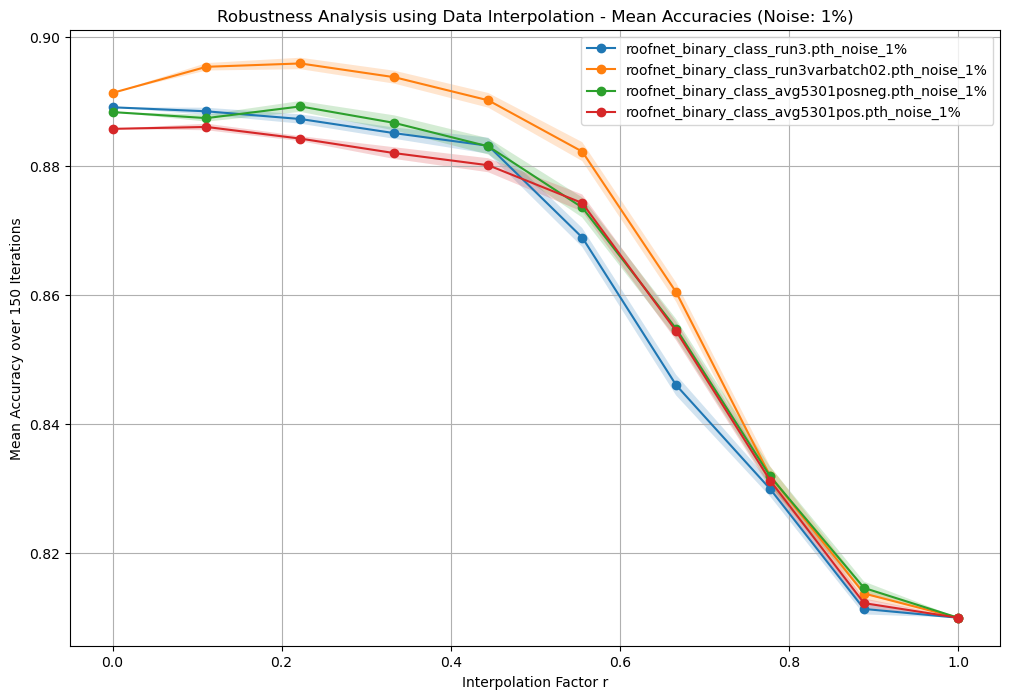

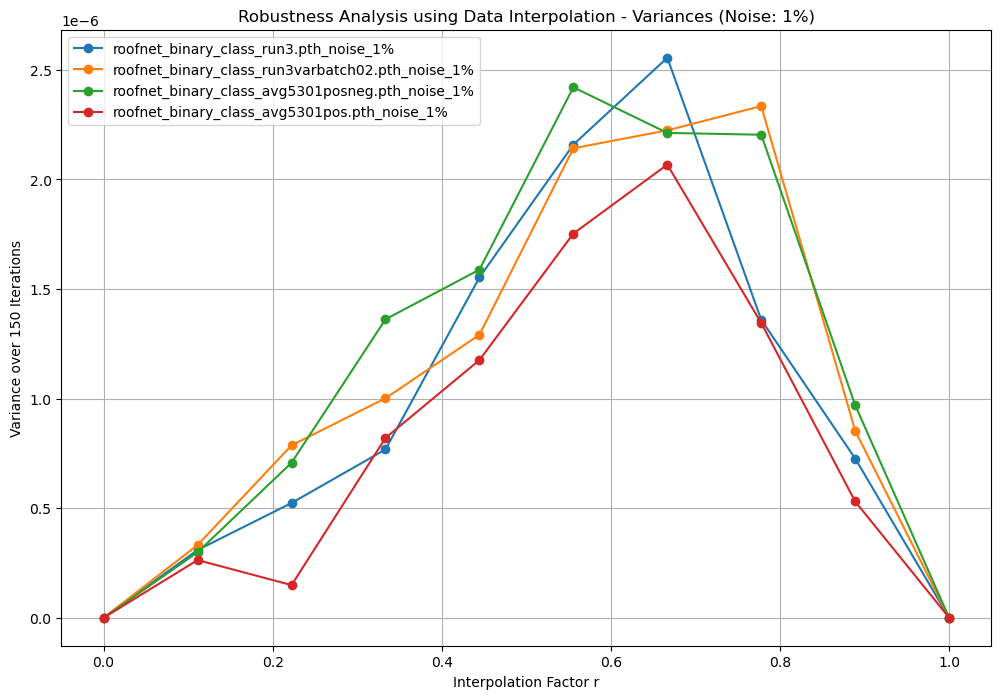

In [62]:
# Assuming test_hold and test_label are defined and contain the test data and labels
robustness_scores = robustness_analysis_using_interpolation(test_hold, test_label, models, device)

### Class-wise Accuracy Score

In [54]:
# Instantiate and load your models
model_dir = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/'  # specify your path
model_names = ['roofnet_binary_class_run3.pth', 'roofnet_binary_class_run3varbatch02.pth', 'roofnet_binary_class_avg5301posneg.pth', 'roofnet_binary_class_avg5301pos.pth']
models = []

for name in model_names:
    model = Net()
    model.load_state_dict(torch.load(model_dir + name))
    model.eval()
    model.to(device)
    models.append(model)

# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
from sklearn.metrics import confusion_matrix

def evaluate_model_on_interpolated_data(data, true_labels, model, device, r, noise_std_dev):
    # Interpolate data with noise
    interpolated_data = interpolate_with_normalized_noise(data, r, noise_std_dev)

    # Convert numpy data to PyTorch tensor and send to device
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    # Make predictions with the model
    with torch.no_grad():
        predictions = model(interpolated_data)

    # Convert model outputs to binary predictions 
    predicted_labels = (predictions > 0.5).float().cpu().numpy().flatten()

    # Compute the confusion matrix
    conf_mat = confusion_matrix(true_labels, predicted_labels)
    
    # Calculate class-wise accuracy using the confusion matrix
    accuracy_class0 = conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1])
    accuracy_class1 = conf_mat[1][1] / (conf_mat[1][0] + conf_mat[1][1])

    return accuracy_class0, accuracy_class1



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def robustness_analysis_using_interpolation(data, meta, models, device, model_names, r_values=np.linspace(0, 1, 10), noise_percentages=[0.01, 0.10, 0.25, 0.50], n_iterations=150):
    model_accuracies = {}
    model_variances = {}
    
    data_range = np.max(data) - np.min(data) 
    
    for noise_percentage in noise_percentages:
        noise_std_dev = data_range * noise_percentage
        
        for model, name in zip(models, model_names):
            all_accuracies_class0 = []
            all_accuracies_class1 = []

            for r in r_values:
                accuracies_for_r_class0 = []
                accuracies_for_r_class1 = []
                
                for _ in range(n_iterations):
                    accuracy_class0, accuracy_class1 = evaluate_model_on_interpolated_data(data, meta, model, device, r, noise_std_dev)
                    accuracies_for_r_class0.append(accuracy_class0)
                    accuracies_for_r_class1.append(accuracy_class1)
                    
                all_accuracies_class0.append(accuracies_for_r_class0)
                all_accuracies_class1.append(accuracies_for_r_class1)

            mean_accuracies_class0 = np.mean(all_accuracies_class0, axis=1)
            variance_accuracies_class0 = np.var(all_accuracies_class0, axis=1)
            mean_accuracies_class1 = np.mean(all_accuracies_class1, axis=1)
            variance_accuracies_class1 = np.var(all_accuracies_class1, axis=1)

            model_name_with_noise = f"{name}_noise_{int(noise_percentage*100)}%"
            model_accuracies[model_name_with_noise] = {"class0": mean_accuracies_class0, "class1": mean_accuracies_class1}
            model_variances[model_name_with_noise] = {"class0": variance_accuracies_class0, "class1": variance_accuracies_class1}
        

        # Plotting accuracies for this noise level for both classes separately
        for class_label, class_name in [("class0", "Class 0"), ("class1", "Class 1")]:
            plt.figure(figsize=(12, 8))
            for model_name, accuracies in model_accuracies.items():
                if f"noise_{int(noise_percentage*100)}%" in model_name:
                    plt.plot(r_values, accuracies[class_label], '-o', label=model_name)
                    plt.fill_between(r_values, accuracies[class_label] - np.sqrt(model_variances[model_name][class_label]), accuracies[class_label] + np.sqrt(model_variances[model_name][class_label]), alpha=0.2)

            plt.title(f'Robustness Analysis using Data Interpolation - Mean Accuracies for {class_name} (Noise: {int(noise_percentage*100)}%)')
            plt.xlabel('Interpolation Factor r')
            plt.ylabel(f'Mean Accuracy over {n_iterations} Iterations')
            plt.legend()
            plt.grid(True)
            plt.show()



        # Plotting variances for this noise level
        plt.figure(figsize=(12, 8))
        for model_name, variance in model_variances.items():
            if f"noise_{int(noise_percentage*100)}%" in model_name:
                plt.plot(r_values, variance, '-o', label=model_name)
                
        plt.title(f'Robustness Analysis using Data Interpolation - Variances (Noise: {int(noise_percentage*100)}%)')
        plt.xlabel('Interpolation Factor r')
        plt.ylabel(f'Variance over {n_iterations} Iterations')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(model_accuracies)
    results_df.insert(0, "Interpolation_Factor_r", r_values)  # Add the r_values as a column for reference
    results_df.to_csv('robustness_accuracies_interpolate_classwise3.csv', index=False)


    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(model_variances)
    results_df.insert(0, "Interpolation_Factor_r", r_values)  # Add the r_values as a column for reference
    results_df.to_csv('robustness_variances_interpolate_classwise3.csv', index=False)
    


    return model_accuracies, model_variances
   

In [56]:
# Assuming test_hold and test_label are defined and contain the test data and labels
robustness_scores = robustness_analysis_using_interpolation(test_hold, test_label, models, device, model_names)

KeyboardInterrupt: 

## Other Performance Metrics

In [160]:
# Instantiate and load your models
model_dir = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/'  # specify your path
model_names = ['roofnet_binary_class_run3.pth', 'roofnet_binary_class_run3varbatch02.pth', 'roofnet_binary_class_avg5301posneg.pth', 'roofnet_binary_class_avg5301pos.pth']
models = []

for name in model_names:
    model = Net()
    model.load_state_dict(torch.load(model_dir + name))
    model.eval()
    model.to(device)
    models.append(model)

# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [167]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def get_predictions_and_probs(model, data):
    # Convert data to a tensor if it's not already one
    if not isinstance(data, torch.Tensor):
        data = torch.Tensor(data)
    
    # Move data to the same device as the model
    data = data.to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probabilities = torch.sigmoid(logits)
    
    predicted_labels = (probabilities > 0.5).float().cpu().numpy()
    predicted_probs = probabilities.cpu().numpy().squeeze()

    return predicted_labels, predicted_probs



for idx, model in enumerate(models):
    predicted_labels, predicted_probs = get_predictions_and_probs(model, test_hold)
    
    precision = precision_score(test_label, predicted_labels)
    recall = recall_score(test_label, predicted_labels)
    f1 = f1_score(test_label, predicted_labels)
    roc_auc = roc_auc_score(test_label, predicted_probs)
    
    print(f"Metrics for {model_names[idx]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print("-" * 30)


Metrics for roofnet_binary_class_run2.pth:
Precision: 0.19
Recall: 1.00
F1-score: 0.32
ROC-AUC: 0.92
------------------------------
Metrics for roofnet_binary_class_topfeatureshap_25_run2.pth:
Precision: 0.20
Recall: 1.00
F1-score: 0.33
ROC-AUC: 0.90
------------------------------
Metrics for roofnet_binary_class_shap_var_batch_run201.pth:
Precision: 0.19
Recall: 0.99
F1-score: 0.32
ROC-AUC: 0.90
------------------------------
Metrics for roofnet_binary_class_shap_var_batch_run203.pth:
Precision: 0.19
Recall: 0.98
F1-score: 0.32
ROC-AUC: 0.88
------------------------------
Metrics for roofnet_binary_class_shap_avg3_run2.pth:
Precision: 0.19
Recall: 1.00
F1-score: 0.32
ROC-AUC: 0.92
------------------------------


## DATA CHECK 

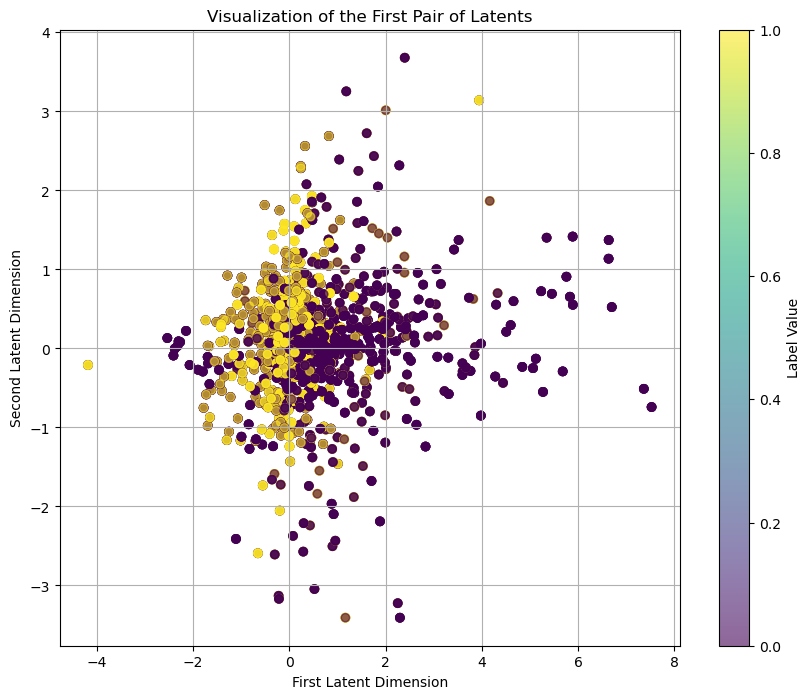

In [95]:
import matplotlib.pyplot as plt

# Extract the first and second latent dimensions
x = data_hold[:, 201]
y = data_hold[:, 200]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=label_hold, cmap='viridis', alpha=0.6)
plt.colorbar(label='Label Value')
plt.title('Visualization of the First Pair of Latents')
plt.xlabel('First Latent Dimension')
plt.ylabel('Second Latent Dimension')
plt.grid(True)
plt.show()




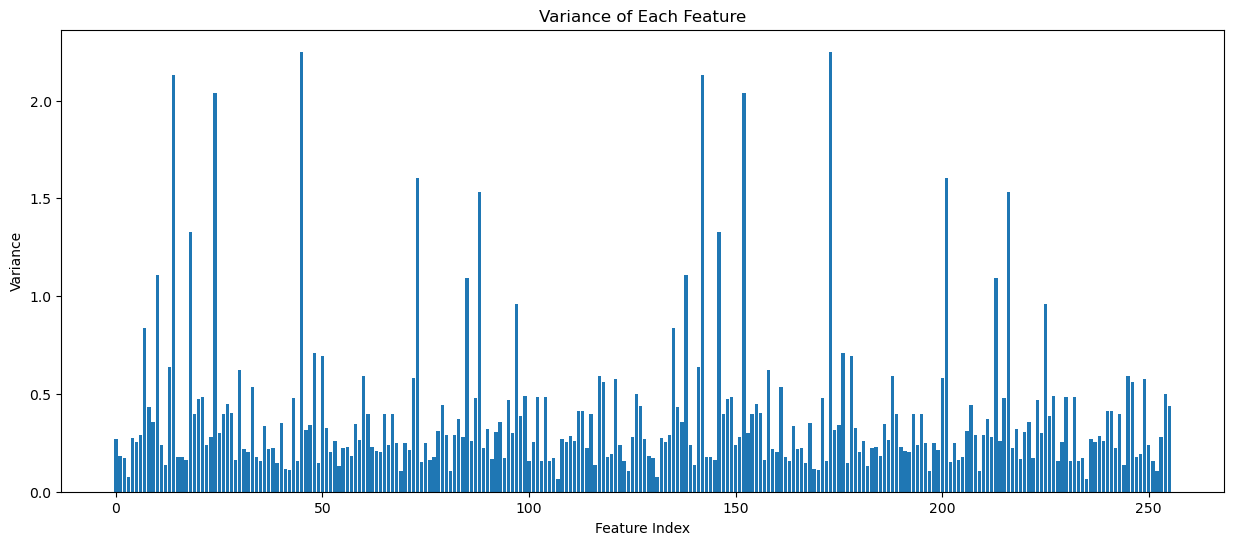

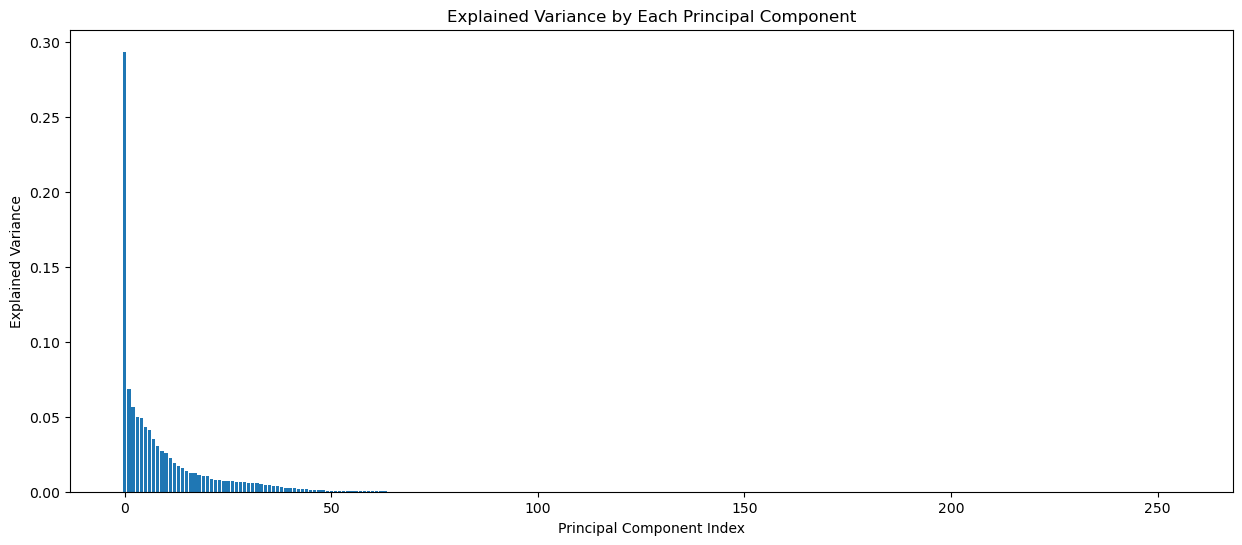

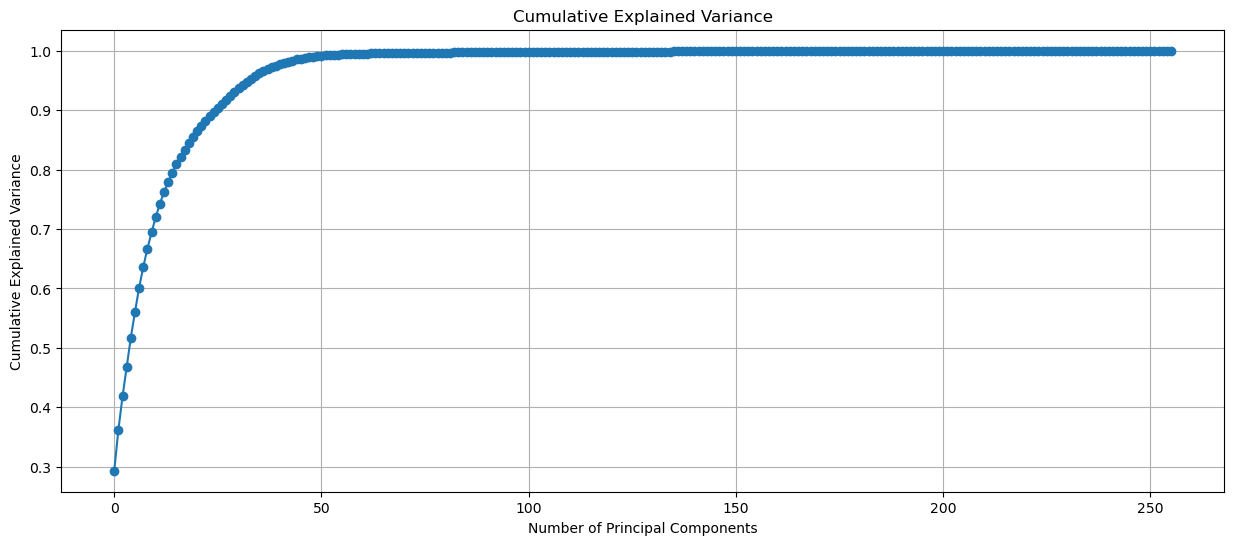

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Compute variance for each feature
feature_variances = np.var(data_hold, axis=0)

# 2. Visualize feature variances
plt.figure(figsize=(15, 6))
plt.bar(range(256), feature_variances)
plt.title('Variance of Each Feature')
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.show()

# 3. Apply PCA
pca = PCA(n_components=256)  # Using all components for now
pca.fit(data_hold)

# Visualize variance explained by each principal component
explained_variances = pca.explained_variance_ratio_

plt.figure(figsize=(15, 6))
plt.bar(range(256), explained_variances)
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance')
plt.show()

# Cumulative variance explained
cumulative_explained_variances = np.cumsum(explained_variances)

plt.figure(figsize=(15, 6))
plt.plot(range(256), cumulative_explained_variances, '-o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()



In [96]:
import pandas as pd

# Assuming data_hold is a 2D array, and we convert it into a DataFrame
df = pd.DataFrame(data_hold)

# Compute and print descriptive statistics
print(df.describe())

# Compute skewness and kurtosis
print("\nSkewness:\n", df.skew())
print("\nKurtosis:\n", df.kurtosis())


               0            1            2            3            4    \
count  7350.000000  7350.000000  7350.000000  7350.000000  7350.000000   
mean      0.023442     0.062621    -0.165723     0.009624     0.022514   
std       0.517856     0.427457     0.417841     0.270451     0.524322   
min      -2.374970    -2.098397    -1.993652    -1.032223    -1.874670   
25%      -0.196943    -0.108039    -0.375400    -0.139607    -0.206983   
50%      -0.002583     0.118552    -0.105966     0.034346    -0.017393   
75%       0.234185     0.275239     0.060654     0.184695     0.226256   
max       2.807027     1.538368     1.346427     0.962009     2.839507   

               5            6            7            8            9    ...  \
count  7350.000000  7350.000000  7350.000000  7350.000000  7350.000000  ...   
mean     -0.051451    -0.510519     0.021187     0.191212    -0.145003  ...   
std       0.504020     0.538783     0.914387     0.658413     0.595962  ...   
min      -2.25503

In [97]:
import pandas as pd

# Convert data_hold into a DataFrame
df = pd.DataFrame(data_hold)

# Calculate the mean, median, skewness, and standard deviation
mean_values = df.mean()
median_values = df.median()
skewness_values = df.skew()
stdev_values = df.std()

# Print out the statistics for each feature
print("Mean Values:\n", mean_values)
print("\nMedian Values:\n", median_values)
print("\nSkewness Values:\n", skewness_values)
print("\nStandard Deviation Values:\n", stdev_values)


Mean Values:
 0      0.023442
1      0.062620
2     -0.165724
3      0.009624
4      0.022514
         ...   
251   -0.037355
252    0.048190
253    0.052332
254   -0.007573
255   -0.051173
Length: 256, dtype: float32

Median Values:
 0     -0.002583
1      0.118552
2     -0.105966
3      0.034346
4     -0.017393
         ...   
251   -0.082333
252    0.058653
253    0.040949
254    0.047520
255   -0.031049
Length: 256, dtype: float32

Skewness Values:
 0      0.419130
1     -0.703401
2     -0.121222
3     -0.373841
4      0.522780
         ...   
251    0.417010
252   -0.075855
253   -0.277849
254    0.006533
255   -0.058857
Length: 256, dtype: float32

Standard Deviation Values:
 0      0.517856
1      0.427457
2      0.417841
3      0.270451
4      0.524322
         ...   
251    0.393628
252    0.324009
253    0.527188
254    0.706774
255    0.664026
Length: 256, dtype: float32


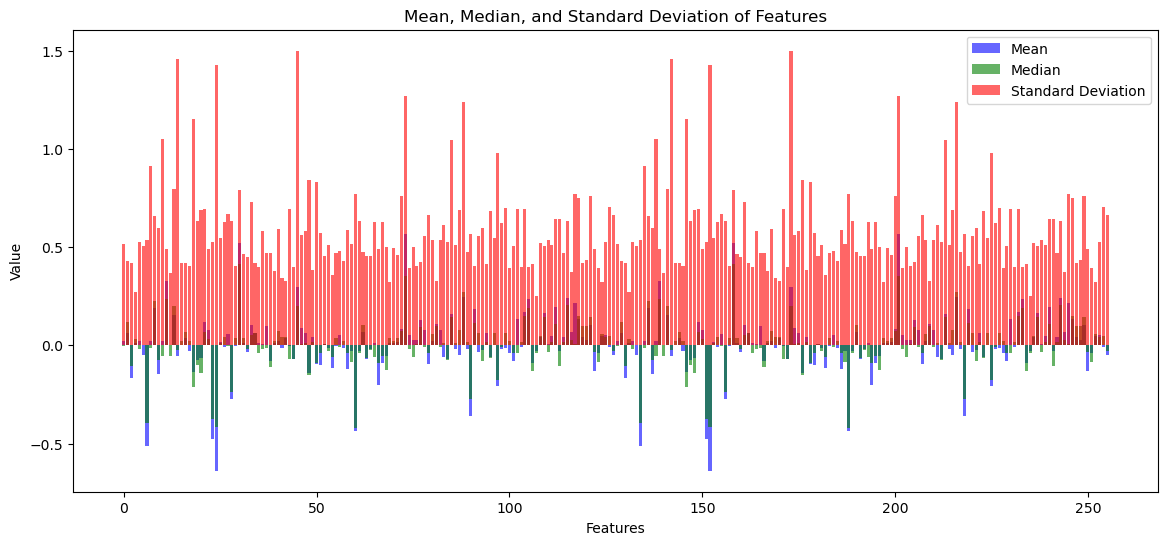

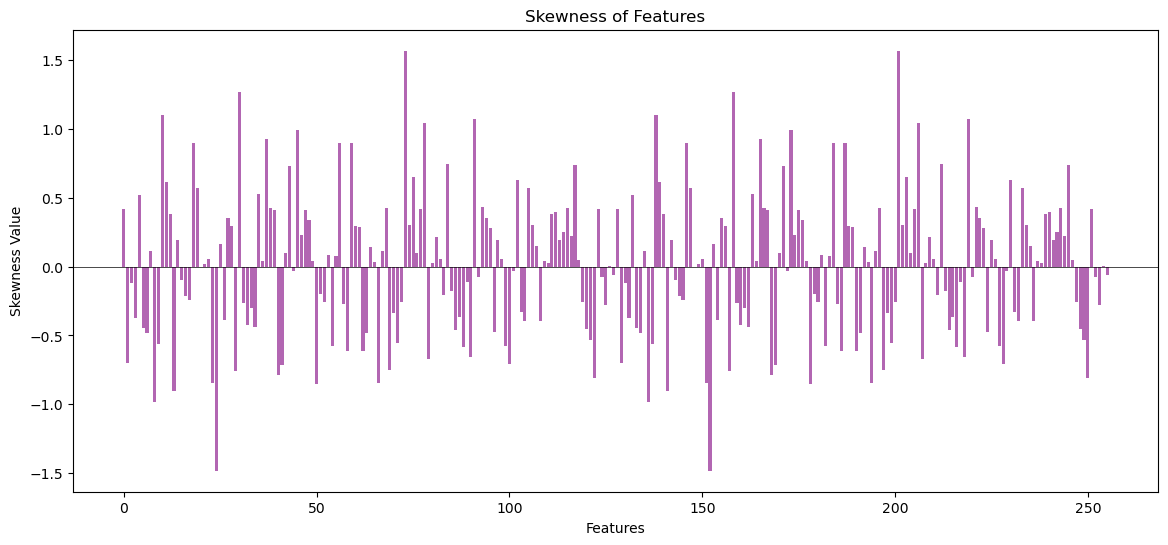

In [98]:
import matplotlib.pyplot as plt

# Convert data_hold into a DataFrame (assuming it's a numpy array)
df = pd.DataFrame(data_hold)

# Calculate the mean, median, skewness, and standard deviation
mean_values = df.mean()
median_values = df.median()
skewness_values = df.skew()
stdev_values = df.std()

# Plot Mean, Median, and Standard Deviation
plt.figure(figsize=(14, 6))
plt.bar(mean_values.index, mean_values.values, alpha=0.6, label='Mean', color='blue')
plt.bar(median_values.index, median_values.values, alpha=0.6, label='Median', color='green')
plt.bar(stdev_values.index, stdev_values.values, alpha=0.6, label='Standard Deviation', color='red')
plt.legend()
plt.title("Mean, Median, and Standard Deviation of Features")
plt.xlabel("Features")
plt.ylabel("Value")
plt.show()

# Plot Skewness
plt.figure(figsize=(14, 6))
plt.bar(skewness_values.index, skewness_values.values, alpha=0.6, color='purple')
plt.title("Skewness of Features")
plt.xlabel("Features")
plt.ylabel("Skewness Value")
plt.axhline(0, color='black', linewidth=0.5)  # Add line at y=0 for reference
plt.show()


In [99]:
import numpy as np

# Assuming data_hold is your dataset
means = np.mean(data_hold, axis=0)         # Mean of each feature
std_devs = np.std(data_hold, axis=0)       # Standard Deviation of each feature

# Avoid division by zero: Add a small value to means
means += 1e-10 

CVs = std_devs / means                      # Coefficient of Variation for each feature

print(CVs)


[  22.088982     6.8257146   -2.5211415   28.099089    23.287516
   -9.795457    -1.0552877   43.15551      3.4431546   -4.1097045
   51.589275     1.4846817 1048.0195       5.097854   -25.731245
  192.78622     11.090448   -13.791724    -8.391326    -8.746837
  -10.386916     5.962121     6.244045    -1.1036761   -2.2353818
   30.46509    -80.24237     11.80366     -2.3094816 -386.41644
    1.5080671   45.96894    -13.607453     7.1022887    6.6549077
   29.160574   130.91316      4.731643    -6.012631    37.036255
   26.28367    -26.23278      9.066462  -127.87088     -5.8429275
    5.0198355    6.186952     9.402263    -5.8814473    8.913323
   -8.643875    -5.7683353  104.687805   -37.960823    -3.0643427
 -133.52347      9.342884   -32.883614    -4.792688   -17.092827
   -1.7665025  -20.1747       6.95664     -6.702811   -27.261295
   65.44415     -2.4087684   -7.189951    -8.825228    34.29633
   41.70122     24.96553      9.114692     2.2353134    7.6920056
   17.40805     13.57

In [107]:
import numpy as np

# Assuming data_hold is your dataset
means = np.mean(data_hold, axis=0)         # Mean of each feature
std_devs = np.std(data_hold, axis=0)       # Standard Deviation of each feature

# Avoid division by zero: Add a small value to means
means += 1e-10 

CVs = std_devs / means                      # Coefficient of Variation for each feature

# Define a threshold for what you consider a small CV
threshold = 0.1


# Count how many features have a CV below the threshold
num_small_CVs = np.sum(CVs <= threshold)

print(f"Number of features with CV < {threshold}: {num_small_CVs}")


Number of features with CV < 0.1: 116
